In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

c:\Users\chith\anaconda3\envs\pyt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['actinic keratosis',
               'basal cell carcinoma',
               'dermatofibroma', 
               'melanoma', 
               'nevus', 
               'pigmented benign keratosis', 
               'seborrheic keratosis', 
               'squamous cell carcinoma', 
               'vascular lesion' ]

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

c:\Users\chith\anaconda3\envs\pyt\lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 9]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [5]:
# Setup directory paths to train and test images
train_dir = 'skin_cancer_ISIC/Train'
test_dir = 'skin_cancer_ISIC/Test'

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [9]:
# for batch in train_dataloader_pretrained:
#     data, labels = batch  # Assuming each batch consists of (data, labels)
#     print("Shape of data in batch:", data.shape)
#     print("Shape of labels in batch:", labels.shape)
#     break  # Break after printing the shape of the first batch

In [10]:
print(train_dataloader_pretrained)

In [11]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [02:34<49:04, 154.98s/it]

Epoch: 1 | train_loss: 1.5953 | train_acc: 0.4588 | test_loss: 1.5711 | test_acc: 0.4396


 10%|█         | 2/20 [05:16<47:42, 159.03s/it]

Epoch: 2 | train_loss: 1.2032 | train_acc: 0.6119 | test_loss: 1.4309 | test_acc: 0.5163


 15%|█▌        | 3/20 [08:07<46:30, 164.13s/it]

Epoch: 3 | train_loss: 1.0700 | train_acc: 0.6476 | test_loss: 1.4349 | test_acc: 0.5476


 20%|██        | 4/20 [14:34<1:07:15, 252.22s/it]

Epoch: 4 | train_loss: 0.9785 | train_acc: 0.6770 | test_loss: 1.4896 | test_acc: 0.4901


 25%|██▌       | 5/20 [20:32<1:12:35, 290.40s/it]

Epoch: 5 | train_loss: 0.9247 | train_acc: 0.6914 | test_loss: 1.4475 | test_acc: 0.5170


 30%|███       | 6/20 [26:47<1:14:28, 319.20s/it]

Epoch: 6 | train_loss: 0.8725 | train_acc: 0.7025 | test_loss: 1.3450 | test_acc: 0.5355


 35%|███▌      | 7/20 [32:47<1:12:01, 332.44s/it]

Epoch: 7 | train_loss: 0.8334 | train_acc: 0.7226 | test_loss: 1.3129 | test_acc: 0.5625


 40%|████      | 8/20 [2:05:33<6:39:42, 1998.55s/it]

Epoch: 8 | train_loss: 0.7956 | train_acc: 0.7298 | test_loss: 1.3230 | test_acc: 0.5504


 45%|████▌     | 9/20 [2:08:44<4:22:50, 1433.68s/it]

Epoch: 9 | train_loss: 0.7741 | train_acc: 0.7409 | test_loss: 1.3470 | test_acc: 0.5547


 50%|█████     | 10/20 [2:11:51<2:54:46, 1048.60s/it]

Epoch: 10 | train_loss: 0.7500 | train_acc: 0.7405 | test_loss: 1.3342 | test_acc: 0.5781


 55%|█████▌    | 11/20 [2:14:53<1:57:30, 783.39s/it] 

Epoch: 11 | train_loss: 0.7170 | train_acc: 0.7561 | test_loss: 1.3655 | test_acc: 0.5582


 60%|██████    | 12/20 [2:17:51<1:19:54, 599.30s/it]

Epoch: 12 | train_loss: 0.6989 | train_acc: 0.7619 | test_loss: 1.3063 | test_acc: 0.6051


 65%|██████▌   | 13/20 [2:19:42<52:39, 451.42s/it]  

Epoch: 13 | train_loss: 0.6820 | train_acc: 0.7664 | test_loss: 1.3722 | test_acc: 0.5582


 70%|███████   | 14/20 [2:21:51<35:24, 354.04s/it]

Epoch: 14 | train_loss: 0.6658 | train_acc: 0.7753 | test_loss: 1.3765 | test_acc: 0.5391


 75%|███████▌  | 15/20 [2:23:16<22:44, 273.00s/it]

Epoch: 15 | train_loss: 0.6552 | train_acc: 0.7763 | test_loss: 1.3114 | test_acc: 0.5817


 80%|████████  | 16/20 [2:24:41<14:25, 216.38s/it]

Epoch: 16 | train_loss: 0.6357 | train_acc: 0.7847 | test_loss: 1.2942 | test_acc: 0.5817


 85%|████████▌ | 17/20 [2:26:10<08:53, 177.90s/it]

Epoch: 17 | train_loss: 0.6339 | train_acc: 0.7820 | test_loss: 1.3336 | test_acc: 0.5817


 90%|█████████ | 18/20 [2:27:50<05:09, 154.64s/it]

Epoch: 18 | train_loss: 0.6126 | train_acc: 0.7910 | test_loss: 1.4189 | test_acc: 0.5398


 95%|█████████▌| 19/20 [2:29:34<02:19, 139.41s/it]

Epoch: 19 | train_loss: 0.5998 | train_acc: 0.7959 | test_loss: 1.4198 | test_acc: 0.5582


100%|██████████| 20/20 [2:31:13<00:00, 453.67s/it]

Epoch: 20 | train_loss: 0.5924 | train_acc: 0.7914 | test_loss: 1.2690 | test_acc: 0.5817


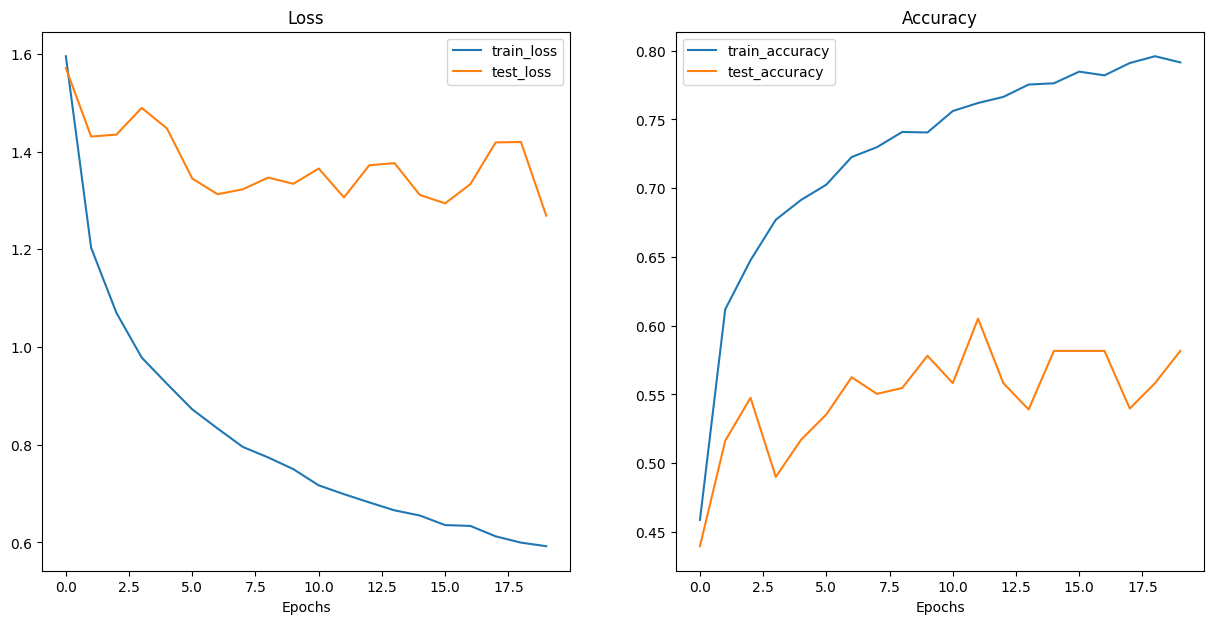

In [12]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

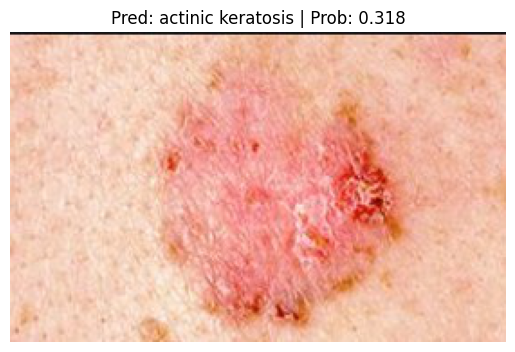

In [13]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "Basal_Cell.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

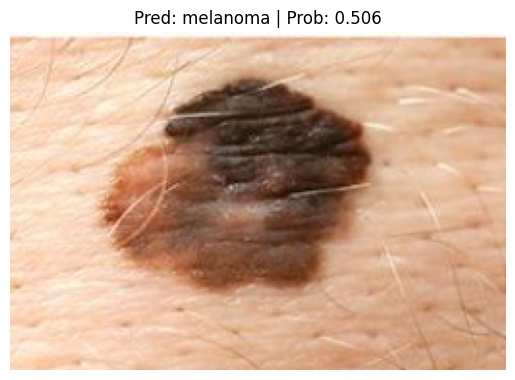

In [14]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "Melanoma.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

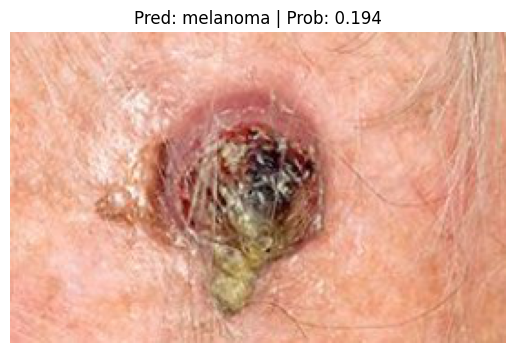

In [15]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "Squamous_cell.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

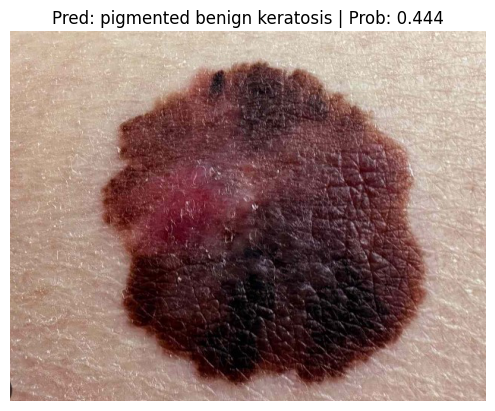

In [16]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "Unknown.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)